In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x
!pip install -q keras-vggface
!pip install -q scikit-image
!pip install -q pydot
!pip install -q keras==2.2.5
!pip install h5py==2.10.0  

TensorFlow 1.x selected.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [ ]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

mfile = '/content/drive/MyDrive/aml/saved/vgg/my_best_model.epoch{epoch:02d}-loss{val_loss:.3f}.hdf5'
msave = keras.callbacks.ModelCheckpoint(filepath=mfile,verbose=1, save_weights_only=True,period= 10 )

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])





58916864/58909280 [==============================] - 1s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/train.zip' -d train

! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/test-public.zip' -d dev

! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/test-private.zip' -d test

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=100,
    callbacks=[rlrop, msave],
    use_multiprocessing=False,
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
224/224 [==============================] - 363s 2s/step - loss: 1.4485 - acc: 0.4508 - val_loss: 1.1859 - val_acc: 0.5700
Epoch 2/100
224/224 [==============================] - 347s 2s/step - loss: 1.1922 - acc: 0.5548 - val_loss: 1.1108 - val_acc: 0.5874
Epoch 3/100
224/224 [==============================] - 346s 2s/step - loss: 1.1493 - acc: 0.5713 - val_loss: 1.0813 - val_acc: 0.5998
Epoch 4/100
224/224 [==============================] - 348s 2s/step - loss: 1.1191 - acc: 0.5827 - val_loss: 1.0500 - val_acc: 0.6047
Epoch 5/100
224/224 [==============================] - 342s 2s/step - loss: 1.0984 - acc: 0.5879 - val_loss: 1.0411 - val_acc: 0.6056
Epoch 6/100
224/224 [==============================] - 343s 2s/step - loss: 1.0761 - acc: 0.5991 - val_loss: 1.0336 - val_acc: 0.6206
Epoch 7/100
224/224 [==============================] - 340s 2s/step - loss: 1.0667 - acc: 0.5985 - v

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/saved/vgg/my_best_model.epoch30-loss0.934.hdf5')

In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=70,
    callbacks=[rlrop, msave],
    use_multiprocessing=False,
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/70
224/224 [==============================] - 362s 2s/step - loss: 0.8587 - acc: 0.6813 - val_loss: 0.9267 - val_acc: 0.6596
Epoch 2/70
224/224 [==============================] - 350s 2s/step - loss: 0.8564 - acc: 0.6814 - val_loss: 0.9275 - val_acc: 0.6625
Epoch 3/70
224/224 [==============================] - 355s 2s/step - loss: 0.8448 - acc: 0.6856 - val_loss: 0.9270 - val_acc: 0.6625
Epoch 4/70
224/224 [==============================] - 354s 2s/step - loss: 0.8428 - acc: 0.6888 - val_loss: 0.9232 - val_acc: 0.6663
Epoch 5/70
224/224 [==============================] - 349s 2s/step - loss: 0.8371 - acc: 0.6881 - val_loss: 0.9361 - val_acc: 0.6611
Epoch 6/70
224/224 [==============================] - 350s 2s/step - loss: 0.8256 - acc: 0.6920 - val_loss: 0.9139 - val_acc: 0.6723
Epoch 7/70
224/224 [==============================] - 349s 2s/step - loss: 0.8177 - acc: 0.6967 - val_loss

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/saved/vgg/my_best_model.epoch40-loss0.912.hdf5')

In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=60,
    callbacks=[rlrop, msave],
    use_multiprocessing=False,
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
224/224 [==============================] - 371s 2s/step - loss: 0.7906 - acc: 0.7066 - val_loss: 0.9125 - val_acc: 0.6699
Epoch 2/60
224/224 [==============================] - 361s 2s/step - loss: 0.7807 - acc: 0.7074 - val_loss: 0.9233 - val_acc: 0.6738
Epoch 3/60
224/224 [==============================] - 356s 2s/step - loss: 0.7778 - acc: 0.7106 - val_loss: 0.9072 - val_acc: 0.6787
Epoch 4/60
224/224 [==============================] - 354s 2s/step - loss: 0.7709 - acc: 0.7120 - val_loss: 0.9267 - val_acc: 0.6686
Epoch 5/60
224/224 [==============================] - 358s 2s/step - loss: 0.7614 - acc: 0.7161 - val_loss: 0.9104 - val_acc: 0.6810
Epoch 6/60
224/224 [==============================] - 354s 2s/step - loss: 0.7485 - acc: 0.7211 - val_loss: 0.9164 - val_acc: 0.6712
Epoch 7/60
224/224 [==============================] - 350s 2s/step - loss: 0.7379 - acc: 0.7262 - val_loss

In [ ]:
epoch_str = '-EPOCHS_' + str(100)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/MyDrive/aml/models/' + 'VGG16' + epoch_str + test_acc + '.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/models/VGG16-EPOCHS_100test_acc_0.704.h5')

In [ ]:
results_dev = model.evaluate_generator(dev_generator, 3589 // BS)
print('dev loss:', results_dev[0],", dev acc:", results_dev[1])

dev loss: 0.971646494099072 , dev acc: 0.6908482142857143


In [ ]:
results_test = model.evaluate_generator(test_generator, 3599 // BS)
print('test loss:', results_test[0],", test acc:", results_test[1])

test loss: 0.8914492577314377 , test acc: 0.705078125


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


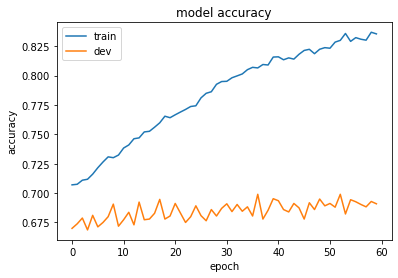

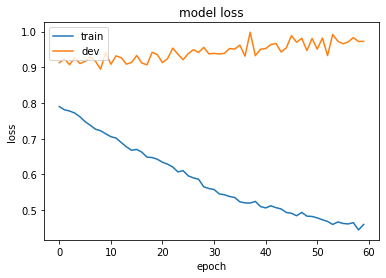

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
a='a'